In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
import mixture
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import collections
from math import pi, cos, sin, cosh, tanh
from scipy.spatial.transform import Rotation as Rot
import cv2
import plotting
from plotting import *
import scipy.interpolate
import scipy.integrate
import scipy.stats
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, LinearRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema
from statistics import median
from scipy.stats import pearsonr

In [2]:
#
# Define colors and states for plotting events.
#
STATES = ['fix', 'sac', 'smp', 'vor', 'blink', 'fix_blink', 'sac_blink', 'other', 'loss']
COLORS = {'fix':'red', 'sac':'lime', 'smp':'purple', 'vor':'brown', 'blink':'dodgerblue', 'fix_blink':'darkorchid', 'sac_blink':'turquoise', 'other':'grey', 'loss':'gold'}
BORDERS = {'fix':'magenta', 'sac':'green', 'smp':'blue', 'vor':'tan', 'blink':'royalblue', 'fix_blink':'darkviolet', 'sac_blink':'lightseagreen', 'other':'black', 'loss':'yellow'}
BINS = 50

## Load data

In [3]:
seq_50 = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/50/all_sequences_50_varjo.csv', index_col=[0])
seq_51 = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/51/all_sequences_51_varjo.csv', index_col=[0])
seq = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv', index_col=[0])
seq_50 = seq_50.loc[:,'HMD':]
seq_51 = seq_51.loc[:,'HMD':]
seq = seq.loc[:,'HMD':]

In [4]:
nn = pd.read_csv('/data/Isabella/thesis_spring2022/NN/results_final.csv', index_col=[0])

In [5]:
# Upload the error data
#errors = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagged_errors.csv', index_col=[0])
errors_ = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/error-tags_full.csv', index_col=[0])

errors_.loc[:, 'subID':'Track'] = errors_.loc[:, 'subID':'Track'].astype(str)
#errors.loc[:, 'Timestamp':'value5b'] = errors.loc[:, 'Timestamp':'value5b'].astype(float)
errors_.loc[:, 'HMD'] = errors_.loc[:, 'HMD'].astype(str)
errors_.loc[:, 'offset'] = errors_.loc[:, 'offset'].astype(bool)
#errors.loc[:, 'Timestamp_adjusted'] = errors.loc[:, 'Timestamp_adjusted'].astype(float)

# Determine whether the type of error is a motor error (and not a process error)
errors_['motor_error'] = False
for idx, row in errors_.iterrows():
    if row.error_type_value1=='1' or row.error_type_value2=='1' or row.error_type_value3=='1' or row.error_type_value4=='1' or row.error_type_value5=='1':
        errors_.loc[idx, 'motor_error'] = True
    
errors = errors_[errors_.motor_error==True]

errors.reset_index(drop=True, inplace=True)

assert all(errors['offset'] == True), "The timestamps of tagged errors have not been adjusted."

In [6]:
# # Use this to create unique identifier 'UID' in the data if it doesn't already exist
# if 'UID' not in seq.columns.tolist():
#     seq['UID'] = ''
#     for idx, row in seq.iterrows():
#         seq.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye
        
# if 'UID' not in seq_50.columns.tolist():
#     seq_50['UID'] = ''
#     for idx, row in seq_50.iterrows():
#         seq_50.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye
        
# if 'UID' not in seq_51.columns.tolist():
#     seq_51['UID'] = ''
#     for idx, row in seq_51.iterrows():
#         seq_51.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye

# del seq['Unnamed: 0.1']
# del seq_50['Unnamed: 0.1']
# del seq_51['Unnamed: 0.1']

# seq.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv')
# seq_50.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/50/all_sequences_50_varjo.csv')
# seq_51.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/51/all_sequences_51_varjo.csv')

# # seq.head()

In [7]:
seq.head()

,HMD,rate,eye,task,subID,VL,event,start_i,end_i,start_s,...,calculus_error,carpenter_error,P_nonfix,P_fix,P_ff,P_smp,P_sac,P_blink,has_blink,UID
0,varjo,200,right,cereal,P19,CVL,smp,0,25,1.081565,...,0.366132,1.527210,0.534494,0.465506,5.470863e-11,0.465506,0.384207,0.150287,0,varjoP19cerealright
1,varjo,200,right,cereal,P19,CVL,fix,26,49,1.211610,...,0.230767,2.684010,0.059622,0.940378,8.531830e-01,0.087195,0.057516,0.002106,0,varjoP19cerealright
2,varjo,200,right,cereal,P19,CVL,sac,50,56,1.326648,...,0.732365,0.474248,0.728794,0.271206,2.022088e-01,0.068997,0.000396,0.728398,0,varjoP19cerealright
3,varjo,200,right,cereal,P19,CVL,noise,57,59,1.361658,...,NaN,NaN,0.667140,0.332860,3.218246e-01,0.011035,0.000000,0.000000,0,varjoP19cerealright
4,varjo,200,right,cereal,P19,CVL,fix,60,205,1.381670,...,0.913183,24.923594,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright


In [8]:
nn

,subID,task,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs
0,P19,sandwich,6.201509,0.595963,0.693136,0.623333,0.518750,0.742857,0.904775,0.945929
0,P24,cereal,6.062364,0.616311,0.690387,0.660526,0.389706,0.811475,0.899842,0.954644
0,P6,sandwich,6.704932,0.542606,0.753285,0.671429,0.593985,0.741497,0.965755,0.957014
0,P5,sandwich,8.287311,0.535820,0.775825,0.716667,0.830882,0.363636,0.991043,0.946807
0,P21,cereal,8.479499,0.363742,0.947434,0.783333,0.724138,0.838710,0.980795,0.963536
0,P9,sandwich,7.457047,0.517842,0.783206,0.586364,0.693694,0.477064,0.951352,0.934658
0,P14,sandwich,7.237658,0.545545,0.761113,0.706250,0.840659,0.528986,0.979543,0.962870
0,P15,cereal,7.027839,0.479974,0.832839,0.800000,0.934783,0.357143,0.989925,0.969305
0,P13,sandwich,6.855649,0.613740,0.692536,0.663333,0.857143,0.257732,0.942627,0.877792
0,P18,cereal,7.451448,0.540611,0.762512,0.654545,0.650350,0.662338,0.963534,0.952354


In [9]:
errs = errors.groupby(['subID','task']).count()

In [10]:
errs = errs.loc[:,'motor_error']

In [11]:
task_errs = errors.groupby(['subID','task']).count()
task_errs = task_errs.loc[:,'motor_error']
num_errs = errors.groupby(['subID']).count()
num_errs = num_errs.loc[:,'motor_error']

nn = nn.set_index('subID')
nn = pd.concat([nn, num_errs], axis=1)
nn = nn.dropna()

In [12]:
# All participants and their respective vision loss
VL_map = {'P2':'CVL', 'P3':'CVL', 'P4':'Other', 'P5':'PVL', 'P6':'CVL', 'P8':'CVL', 'P9':'CVL', 'P10':'CVL',
                'P11':'PVL', 'P12':'PVL', 'P13':'CVL', 'P14':'PVL', 'P15':'PVL', 'P16':'PVL', 'P17':'PVL',
                'P18':'CVL', 'P19':'CVL', 'P21':'CVL', 'P22':'PVL', 'P23':'PVL', 'P24':'PVL', 'P25':'CVL'}

In [13]:
nn['VL'] = [VL_map[subID] for subID in nn.index]

In [14]:
nn

,task,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs,motor_error,VL
subID,,,,,,,,,,,
P19,sandwich,6.201509,0.595963,0.693136,0.623333,0.518750,0.742857,0.904775,0.945929,36,CVL
P24,cereal,6.062364,0.616311,0.690387,0.660526,0.389706,0.811475,0.899842,0.954644,28,PVL
P6,sandwich,6.704932,0.542606,0.753285,0.671429,0.593985,0.741497,0.965755,0.957014,30,CVL
P5,sandwich,8.287311,0.535820,0.775825,0.716667,0.830882,0.363636,0.991043,0.946807,53,PVL
P21,cereal,8.479499,0.363742,0.947434,0.783333,0.724138,0.838710,0.980795,0.963536,36,CVL
P9,sandwich,7.457047,0.517842,0.783206,0.586364,0.693694,0.477064,0.951352,0.934658,23,CVL
P14,sandwich,7.237658,0.545545,0.761113,0.706250,0.840659,0.528986,0.979543,0.962870,53,PVL
P15,cereal,7.027839,0.479974,0.832839,0.800000,0.934783,0.357143,0.989925,0.969305,13,PVL
P13,sandwich,6.855649,0.613740,0.692536,0.663333,0.857143,0.257732,0.942627,0.877792,61,CVL


## Find outliers (noisy datasets)

In [15]:
# get the length of all datasets and calculate ratio of consecutive events
len_datasets = {}
dur_totals = {}
ratio_noise_loss_num = {}
ratio_blinks_num = {}
ratio_noise_loss_dur = {}
ratio_blinks_dur = {}
for HMD in seq.HMD.unique():
    for subID in seq.subID.unique():
        for task in seq.task.unique():
            for eye in seq.eye.unique():
                ID = HMD+subID+task+eye
                temp = seq.loc[(seq.HMD==HMD)&(seq.subID==subID)&(seq.task==task)&(seq.eye==eye)]
                if len(temp) != 0:
                    len_datasets[ID] = len(temp)
                    dur_totals[ID] = sum(temp.duration)
                    ratio_noise_loss_num[ID] = len(temp.loc[(temp.event=='noise') | (temp.event=='loss')])/len(temp)
                    ratio_blinks_num[ID] = len(temp.loc[(temp.event=='blink') | (temp.has_blink==True)])/len(temp)
                    ratio_noise_loss_dur[ID] = sum(temp.loc[(temp.event=='noise') | (temp.event=='loss'), 'duration'])/sum(temp.duration)
                    ratio_blinks_dur[ID] = sum(temp.loc[(temp.event=='blink') | (temp.has_blink==True),'duration'])/sum(temp.duration)


In [16]:
[k for k, v in ratio_noise_loss_num.items() if v == min(ratio_noise_loss_num.values())]

['varjoP3cerealright']

In [17]:
[k for k, v in ratio_noise_loss_dur.items() if v == min(ratio_noise_loss_dur.values())]

['varjoP25sandwichleft']

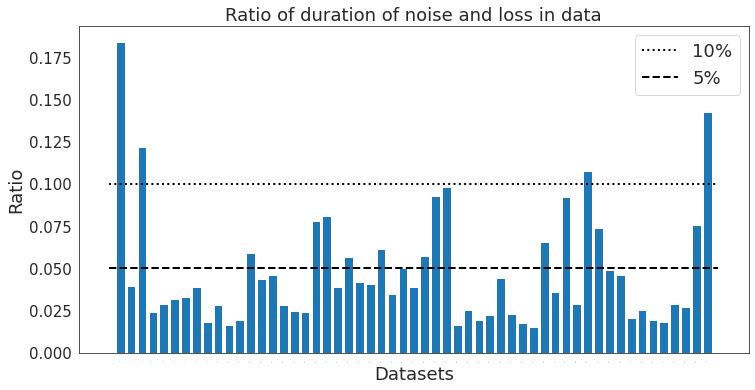

In [18]:
analyze_datasets(ratio_noise_loss_dur, title='Ratio of duration of noise and loss in data')

In [19]:
# # remove datasets where noise and loss account for more than 5% of dataset duration
# high_noise = [k for k,v in ratio_noise_loss_dur.items() if v > 0.10]

# n = len(seq.UID.unique())
# to_drop = []
# for idx, row in seq.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq = seq.drop(to_drop)
# seq.reset_index(inplace=True)

# to_drop = []
# for idx, row in seq_50.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq_50 = seq_50.drop(to_drop)
# seq_50.reset_index(inplace=True)

# to_drop = []
# for idx, row in seq_51.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq_51 = seq_51.drop(to_drop)
# seq_51.reset_index(inplace=True)

# print(f'dropped {len(high_noise)} datasets out of {n} ({np.round(len(high_noise)/n,2)*100}%)\n{high_noise}')

In [20]:
consec_events = []
cov_x, cov_y, d2, d = [], [], [], []
num_consec_e = {}
for idx, row in seq.iterrows():
    if idx == 0:
        continue
    prev_row = seq.loc[idx-1]
    prev_ID = prev_row.HMD+prev_row.subID+prev_row.task+prev_row.eye
    ID = row.HMD+row.subID+row.task+row.eye
    if row.event == prev_row.event and ID == prev_ID:
        if idx-1 not in consec_events:
            consec_events.append(idx-1)
        if idx not in consec_events:
            consec_events.append(idx)
        cov_x.append(np.cov([row.center_x, prev_row.center_x]))
        cov_y.append(np.cov([row.center_y, prev_row.center_y]))
        d.append(np.sqrt((row.center_x-prev_row.center_x)**2+(row.center_y-prev_row.center_y)**2))
        d2.append(np.sqrt((row.x0-prev_row.xn)**2+(row.y0-prev_row.yn)**2))
        if ID in num_consec_e.keys():
            num_consec_e[ID] += 1
        else:
            num_consec_e[ID] = 1

In [77]:
# get the length of all datasets in order to calculate ratio of consecutive events
len_datasets = {}
dur_totals = {}
ratio_noise_loss_num = {}
ratio_blinks_num = {}
ratio_noise_loss_dur = {}
ratio_blinks_dur = {}
for HMD in seq.HMD.unique():
    for subID in seq.subID.unique():
        for task in seq.task.unique():
            for eye in seq.eye.unique():
                ID = HMD+subID+task+eye
                temp = seq.loc[(seq.HMD==HMD)&(seq.subID==subID)&(seq.task==task)&(seq.eye==eye)]
                ID = subID
                if len(temp) != 0:
                    len_datasets[ID] = len(temp)
                    dur_totals[ID] = sum(temp.duration)
                    ratio_noise_loss_num[ID] = len(temp.loc[(temp.event=='noise') | (temp.event=='loss')])/len(temp)
                    ratio_blinks_num[ID] = len(temp.loc[(temp.event=='blink') | (temp.has_blink==True)])/len(temp)
                    ratio_noise_loss_dur[ID] = sum(temp.loc[(temp.event=='noise') | (temp.event=='loss'), 'duration'])/sum(temp.duration)
                    ratio_blinks_dur[ID] = sum(temp.loc[(temp.event=='blink') | (temp.has_blink==True),'duration'])/sum(temp.duration)


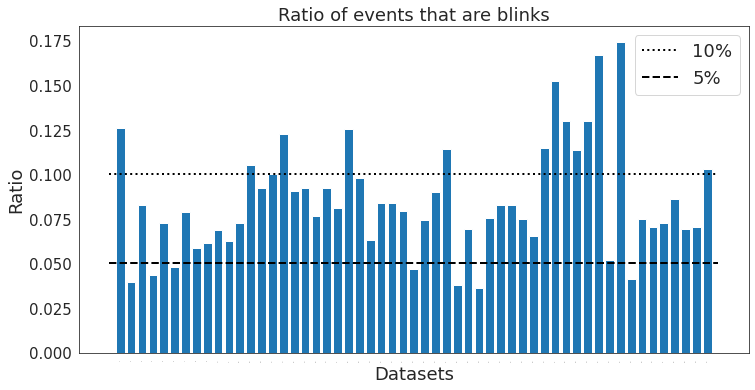

In [22]:
analyze_datasets(ratio_blinks_num, title='Ratio of events that are blinks')

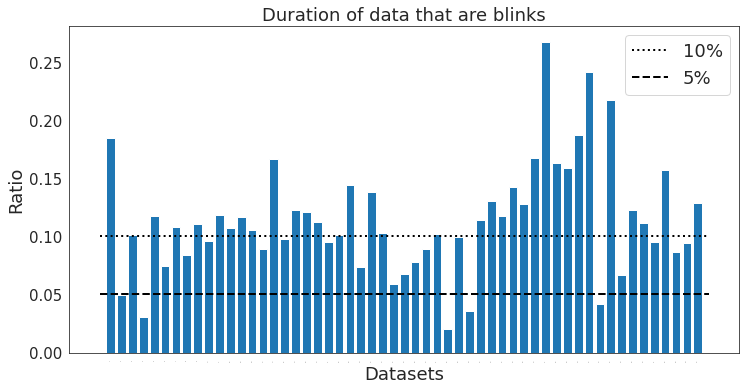

In [23]:
analyze_datasets(ratio_blinks_dur, title='Duration of data that are blinks')

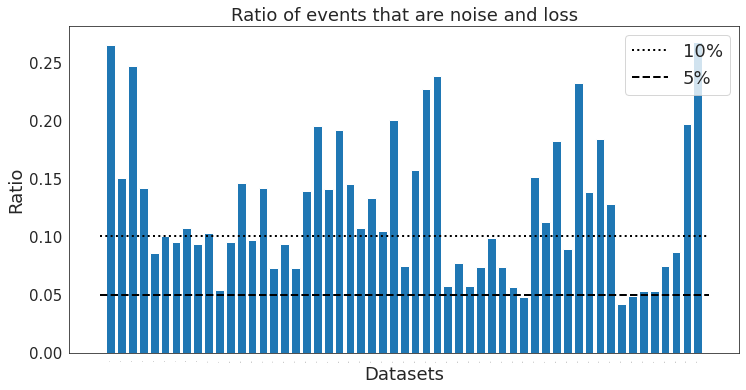

In [24]:
analyze_datasets(ratio_noise_loss_num, title='Ratio of events that are noise and loss')

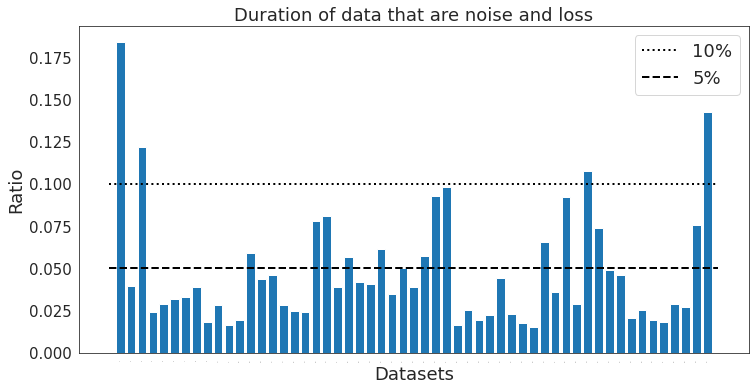

In [25]:
analyze_datasets(ratio_noise_loss_dur, title='Duration of data that are noise and loss')

In [26]:
consec_ratios = {}
for key, value in num_consec_e.items():
    consec_ratios[key] = value/len_datasets[key]

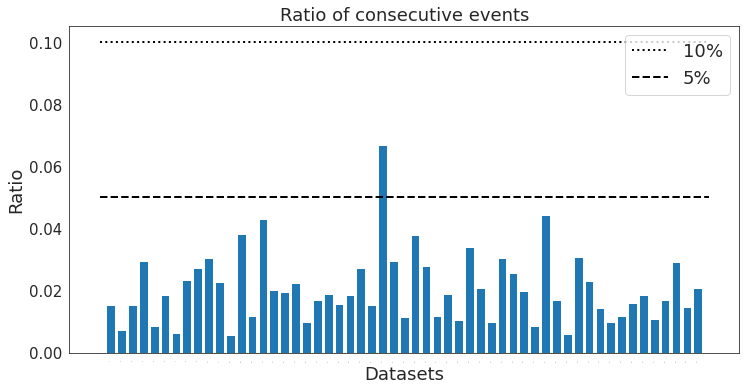

In [27]:
analyze_datasets(consec_ratios, title = 'Ratio of consecutive events')


## Evaluate features before and after additional steps (5.1 and 5.2)

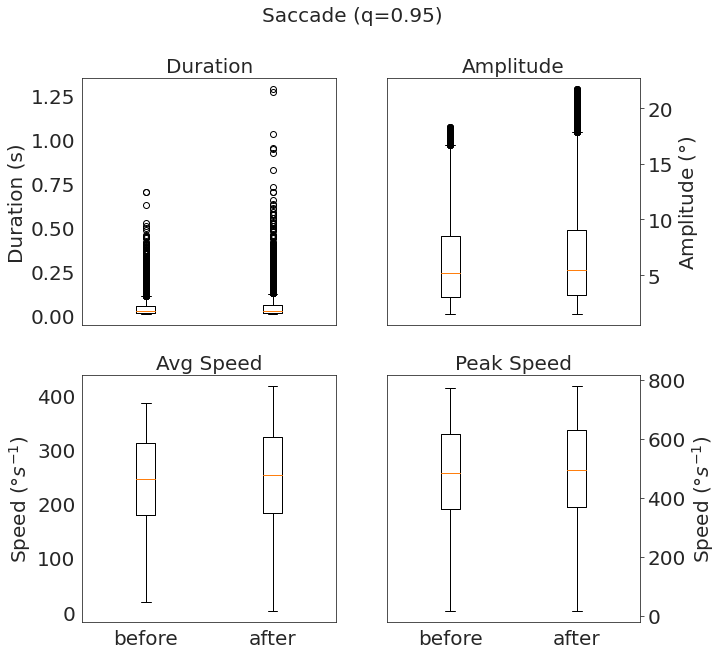

In [41]:
plot_change([seq_50, seq], 'sac', q=0.95)

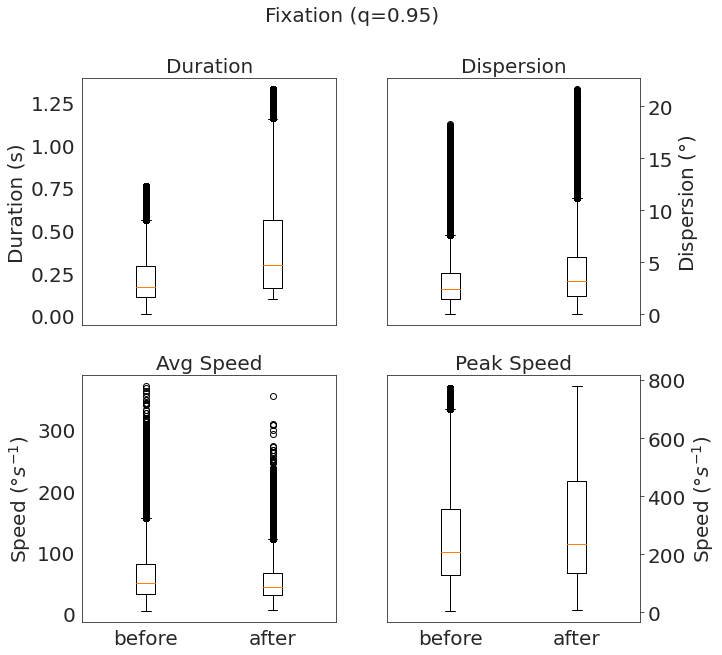

In [13]:
plot_change([seq_50, seq], 'fix', q=0.95)

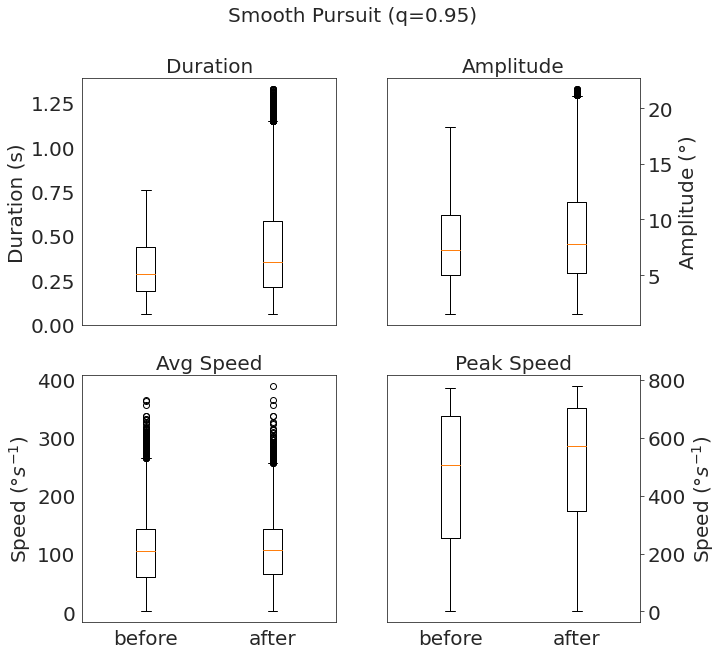

In [14]:
plot_change([seq_50, seq], 'smp', q=0.95)

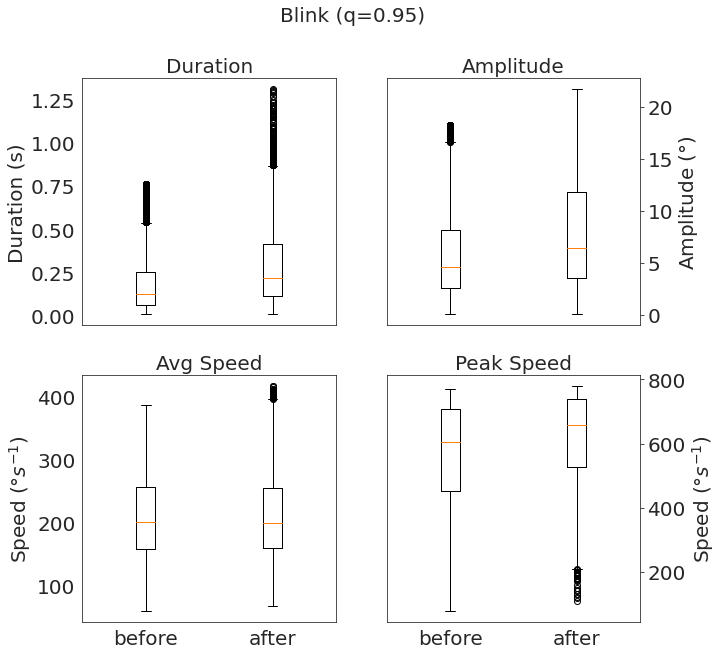

In [15]:
plot_change([seq_50, seq], 'blink', q=.95)

In [16]:
print('Saccades under 1 deg')
print('  step 1:', np.round(len(seq_50.loc[(seq_50.event=='sac')&(seq_50.amplitude<1)])/len(seq_50[seq_50.event=='sac'])*100,2),'%')
print('  step 2:', np.round(len(seq_51.loc[(seq_51.event=='sac')&(seq_51.amplitude<1)])/len(seq_51[seq_51.event=='sac'])*100,2),'%')
print('  step 3:', np.round(len(seq.loc[(seq.event=='sac')&(seq.amplitude<1)])/len(seq[seq.event=='sac'])*100,2),'%')

print('\nSmooth Pursuit under 1 deg')
print('  step 1:', np.round(len(seq_50.loc[(seq_50.event=='smp')&(seq_50.amplitude<1)])/len(seq_50[seq_50.event=='smp'])*100,2),'%')
print('  step 2:', np.round(len(seq_51.loc[(seq_51.event=='smp')&(seq_51.amplitude<1)])/len(seq_51[seq_51.event=='smp'])*100,2),'%')
print('  step 3:', np.round(len(seq.loc[(seq.event=='smp')&(seq.amplitude<1)])/len(seq[seq.event=='smp'])*100,2),'%')


Saccades under 1 deg
  step 1: 0.0 %
  step 2: 0.2 %
  step 3: 0.0 %

Smooth Pursuit under 1 deg
  step 1: 0.0 %
  step 2: 0.07 %
  step 3: 0.0 %


In [17]:
len(seq[seq.task=='sandwich'].UID.unique())

26

## Evaluate correlation between eyes

In [18]:
c = {} # pearson correlations
for subID in seq.subID.unique():
    for task in seq[seq.subID==subID].task.unique():
        temp = seq.loc[(seq.subID==subID)&(seq.task==task)]
        if len(temp.eye.unique()) > 1:
            a = temp.loc[temp.eye == 'left', 'event']
            b = temp.loc[temp.eye == 'right', 'event']
            if len(a) == len(b):
                r, p = pearsonr(a,b)
                c[temp.UID] = [r, p]
if len(c) == 0:
    print('No datasets of equal length')

No datasets of equal length


In [19]:
# for subID, task in c.items():
    
#     r, p = pearsonr(sac_amp,sac_dur)
#     print(f'amp vs dur: r {r}, p {p}, r^2 {r**2}')
#     r, p = pearsonr(sac_amp,sac_avg_iss)
#     print(f'amp vs avg iss: r {r}, p {p}, r^2 {r**2}')
#     r, p = pearsonr(sac_amp,sac_max_iss)
#     print(f'amp vs max iss: r {r}, p {p}, r^2 {r**2}')

## Evaluate consecutive events before and after additional steps (5.1 and 5.2)

In [20]:
print('step 1')
show_transition_matrix(seq_50, normalize=True)

step 1


event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.02,0.11,0.00,0.05,0.09
fix,0.64,0.44,0.76,0.50,0.51
sac,0.01,0.23,0.01,0.10,0.16
smp,0.09,0.17,0.11,0.14,0.15


In [21]:
print('step 2')
show_transition_matrix(seq_51, normalize=True)

step 2


event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.03,0.02,0.00,0.03,0.04
fix,0.51,0.47,0.75,0.50,0.52
sac,0.02,0.26,0.00,0.12,0.18
smp,0.15,0.18,0.12,0.14,0.16


In [22]:
print('step 3')
show_transition_matrix(seq, normalize=True)

step 3


event_i+1,blink,fix,sac,smp,All
event_i,,,,,
blink,0.00,0.05,0.00,0.04,0.05
fix,0.53,0.04,0.74,0.57,0.38
sac,0.03,0.49,0.00,0.14,0.26
smp,0.16,0.32,0.12,0.01,0.19


## Plot carpenter's error (relation between amplitude and duration)

<Figure size 720x720 with 0 Axes>

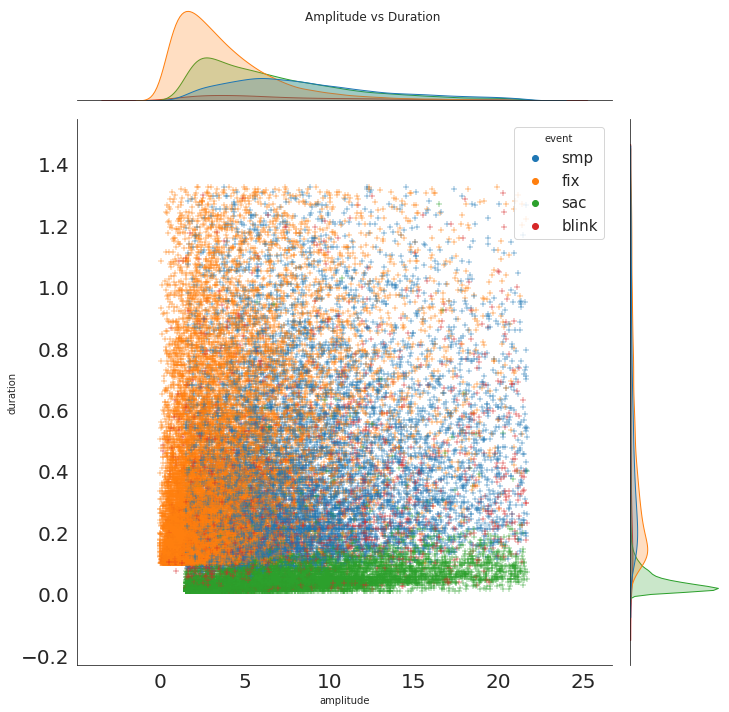

In [23]:
# Plot amplitude vs duration

plt.rc('legend',fontsize=15)
plt.figure(figsize=(10,10))
#sns.set(font_scale=1)
sns.jointplot(data=seq[(seq.event!='loss')&(seq.event!='noise')][seq.amplitude < seq.amplitude.quantile(.95)][seq.duration < seq.duration.quantile(.95)],
              x='amplitude',
              y='duration',
              hue='event',
              marker='+',
              height=10
             )
plt.suptitle('Amplitude vs Duration')
plt.show()

In [24]:
%matplotlib inline

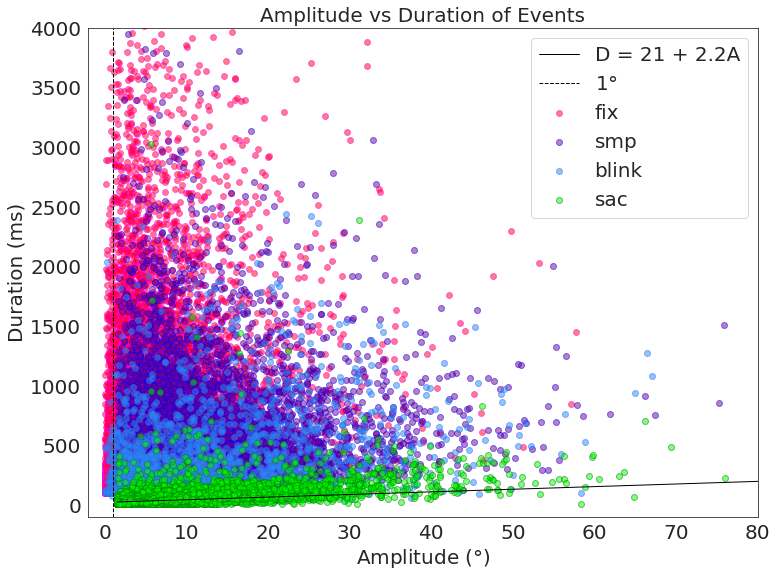

In [25]:
plot_carpenter(seq,show_events=['fix','smp','blink','sac'])

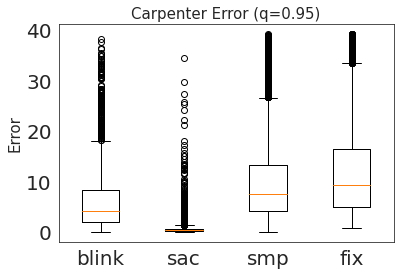

In [26]:
# Plot carpenter error boxplot
q = .95
events = ['blink','sac','smp','fix']
data = []
for e in events:
    data.append((seq[seq.event == e][seq.carpenter_error < seq.carpenter_error.quantile(q)].carpenter_error))
plt.figure()
plt.boxplot(data, labels = events)
plt.title(f'Carpenter Error (q={q})', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.show()

In [125]:
# How about only saccades above 5%, which is what Carpenter found?
seq.loc[(seq.event=='sac')&(seq.amplitude>5)].carpenter_error.describe()


count    6921.000000
mean        0.751176
std         1.810026
min         0.000036
25%         0.195739
50%         0.422240
75%         0.812634
max        88.856078
Name: carpenter_error, dtype: float64

In [27]:
# Show Carpenter error statistics
seq.groupby('event').carpenter_error.describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
blink,2527.0,6.852183,8.167044,0.002328,2.008938,4.239494,8.642587,97.675415
fix,18634.0,17.909466,23.725077,0.804903,5.408444,10.441187,20.763869,462.614439
loss,9.0,22.216337,34.463976,3.637692,4.883417,8.810189,11.011305,108.470439
noise,2042.0,5.380906,6.635588,0.001915,1.313237,3.221703,6.796820,57.677138
sac,12137.0,0.665379,1.461335,0.000036,0.218286,0.443857,0.669133,88.856078
smp,9590.0,11.425560,11.812378,0.063289,4.290842,7.770547,14.037615,160.226766


## Calculus error

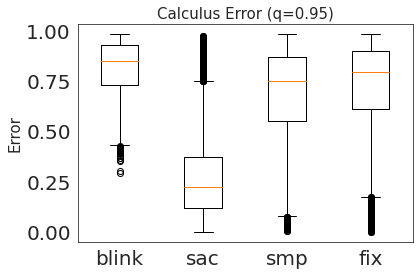

In [28]:
# Plot carpenter error boxplot
q = 0.95
events = ['blink','sac','smp','fix']
data = []
for e in events:
    data.append((seq[seq.event == e][seq.calculus_error < seq.calculus_error.quantile(q)].calculus_error))
plt.figure()
plt.boxplot(data, labels = events)
plt.title(f'Calculus Error (q={q})', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.show()

In [29]:
# Show Calculus error statistics
seq.groupby('event').calculus_error.describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
blink,2527.0,0.846906,0.158808,0.292592,0.750050,0.874068,0.953751,1.495762
fix,18634.0,0.743356,0.222584,0.000674,0.623593,0.807683,0.914920,1.498795
loss,9.0,1.001341,0.010921,0.983763,0.995208,0.998354,1.012996,1.015863
noise,2042.0,0.710434,0.292520,0.000596,0.535191,0.798092,0.928282,1.475516
sac,12137.0,0.276580,0.214822,0.000006,0.121304,0.224967,0.377686,1.473516
smp,9590.0,0.713108,0.235107,0.006051,0.565811,0.764443,0.888800,1.497392


## Overall frequency of events?

In [30]:
for e in ['fix','smp','sac','blink']:
    if e == 'blink':
        f = np.round((sum(seq.has_blink)+len(seq[seq.event=='blink']))/sum(seq.duration),3)
    else:
        f = np.round(len(seq[seq.event==e])/sum(seq.duration),3)

    print(f"Frequency of {e}: {f} s-1")

Frequency of fix: 1.018 s-1
Frequency of smp: 0.524 s-1
Frequency of sac: 0.663 s-1
Frequency of blink: 0.237 s-1


In [31]:
for v in ['PVL', 'CVL']:
    print(v)
    for e in ['fix','smp','sac','blink','loss','noise']:
        temp = seq.loc[seq.VL==v]
        if e == 'blink':
            f = np.round((sum(temp.has_blink)+len(temp[temp.event=='blink']))/sum(temp.duration),3)
        else:
            f = np.round(len(temp[temp.event==e])/sum(temp.duration),3)

        print(f"Frequency of {e}: {f} s-1")

PVL
Frequency of fix: 0.999 s-1
Frequency of smp: 0.534 s-1
Frequency of sac: 0.611 s-1
Frequency of blink: 0.268 s-1
Frequency of loss: 0.0 s-1
Frequency of noise: 0.355 s-1
CVL
Frequency of fix: 1.033 s-1
Frequency of smp: 0.517 s-1
Frequency of sac: 0.703 s-1
Frequency of blink: 0.214 s-1
Frequency of loss: 0.001 s-1
Frequency of noise: 0.362 s-1


In [106]:
# Do saccades adhere to the finding that consecutive saccades cannot occur within 150 ms of each other
# due to path-planning latency?

sac_durs = {}
for UID in seq.UID.unique():
    temp = seq[seq.UID==UID]
    sacs = temp.loc[temp.event=='sac',['duration','end_s']]
    sacs.reset_index(inplace=True)
    sac_durs[UID] = [row.end_s - sacs.loc[i-1,'end_s'] - row.duration for i, row in sacs[1:].iterrows()]

In [121]:
# Do saccades adhere to the finding that consecutive saccades cannot occur within 150 ms of each other
# due to path-planning latency?
sac_dur = []
for l in sac_durs.values():
    sac_dur.extend(l)

In [37]:
%matplotlib notebook

<IPython.core.display.Javascript object>


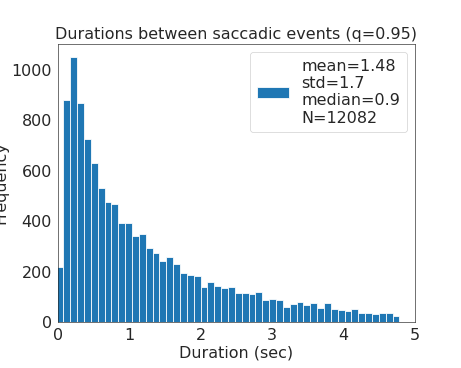

In [38]:
fs = 20
q= 0.95
plt.figure(figsize=(10,8))
stats = f'mean={np.round(np.average(d.d),2)}\nstd={np.round(np.std(d.d),2)}\nmedian={np.round(np.median(d.d),2)}\nN={len(d.d)}'
plt.hist(d.loc[d.d<d.d.quantile(q)], bins=50, label=stats)
plt.xlabel('Duration (sec)',fontsize=fs)
plt.ylabel('Frequency',fontsize=fs)
plt.title(f'Durations between saccadic events (q={q})', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.xlim((0,5))
plt.show()

## Analyze blinks

In [39]:
a = len(seq_50[seq_50.event=='blink'])
b = len(seq[seq.has_blink==1])+len(seq[seq.event=='blink'])
print(f'{np.round((a-b)/a*100,2)}% blinks removed between 5.0 and end')

41.29% blinks removed between 5.0 and end


In [40]:
# # Plot of duration by event (particularly fixation) with has_blink = 1 vs has_blink = 0
# plt.figure(figsize=(15,4))
# plt.bar(seq[seq.has_blink==1].event, seq[seq.has_blink==1].duration, label = 'has_blink=1')
# plt.bar(seq[seq.has_blink==0].event, seq[seq.has_blink==0].duration, label = 'has_blink=0', align='edge',width=0.5)
# #plt.ylim((-0.03,0.01))
# plt.xlabel('event',fontsize=15)
# plt.ylabel('duration (s)',fontsize=15)
# plt.title('Difference in event durations between merged and non-merged',fontsize=15)
# plt.legend(fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid()
# plt.show()

## Linearity of features  - saccadic correlation

<IPython.core.display.Javascript object>


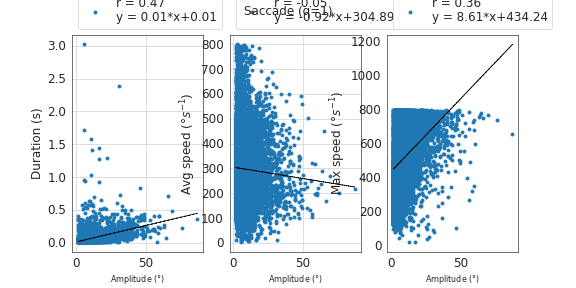

In [110]:
rs, ps = show_correlation(seq,'sac','amplitude')

In [113]:
for k,v in r_coeffs.items():
    print(f'amp vs {k}:  r = {v},  p = {ps[k]}')

amp vs duration:  r = 0.4696573080400682,  p = 0.0
amp vs avg_iss:  r = -0.04739414523128804,  p = 1.8159220952670048e-07
amp vs max_iss:  r = 0.35588918738101816,  p = 0.0


<IPython.core.display.Javascript object>


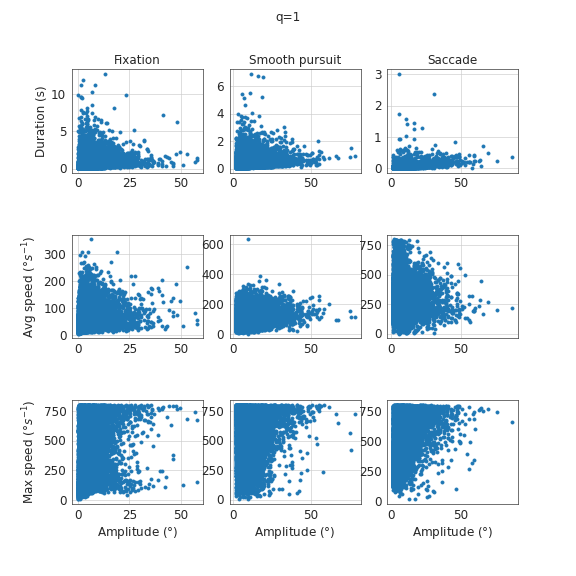

In [43]:
# Plot avg duration, avg velocity, peak velocity as event amplitude increases
# (only sac should show positive linearity)
show_linear_relation(seq)

In [44]:
# Correlation between saccade amplitude, peak velocity, and calculus based error

In [45]:
# show correlation between saccade amplitude, duration, max iss, peak iss using pearson correlation coefficient
# (they should all increase as amp does)

temp = seq.loc[(seq.event=='sac')&(~np.isnan(seq.amplitude))&(~np.isnan(seq.avg_iss))&(~np.isnan(seq.max_iss))]
sac_amp = temp.amplitude
sac_dur = temp.duration
sac_max_iss = temp.max_iss
sac_avg_iss = temp.avg_iss

print('saccades')
r, p = pearsonr(sac_amp,sac_dur)
print(f'amp vs dur: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_avg_iss)
print(f'amp vs avg iss: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_max_iss)
print(f'amp vs max iss: r {r}, p {p}, r^2 {r**2}')

saccades
amp vs dur: r 0.6349172837444459, p 0.0, r^2 0.4031199571974252
amp vs avg iss: r -0.043422495450132326, p 1.8501265178475035e-06, r^2 0.0018855131111167626
amp vs max iss: r 0.3555701587362372, p 0.0, r^2 0.12643013778371293


In [46]:
temp = seq.loc[(seq.event=='fix')&(~np.isnan(seq.amplitude))&(~np.isnan(seq.avg_iss))&(~np.isnan(seq.max_iss))]
sac_amp = temp.amplitude
sac_dur = temp.duration
sac_max_iss = temp.max_iss
sac_avg_iss = temp.avg_iss

print('fixations')
r, p = pearsonr(sac_amp,sac_dur)
print(f'amp vs dur: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_avg_iss)
print(f'amp vs avg iss: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_max_iss)
print(f'amp vs max iss: r {r}, p {p}, r^2 {r**2}')

fixations
amp vs dur: r 0.27385668498323723, p 1.6645813e-317, r^2 0.07499748391000803
amp vs avg iss: r 0.25012128429597985, p 1.7524966494331446e-263, r^2 0.06256065685787038
amp vs max iss: r 0.3182168062239192, p 0.0, r^2 0.10126193576335132


In [47]:
temp = seq.loc[(seq.event=='smp')&(~np.isnan(seq.amplitude))&(~np.isnan(seq.avg_iss))&(~np.isnan(seq.max_iss))]
sac_amp = temp.amplitude
sac_dur = temp.duration
sac_max_iss = temp.max_iss
sac_avg_iss = temp.avg_iss

print('smp')
r, p = pearsonr(sac_amp,sac_dur)
print(f'amp vs dur: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_avg_iss)
print(f'amp vs avg iss: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_max_iss)
print(f'amp vs max iss: r {r}, p {p}, r^2 {r**2}')

smp
amp vs dur: r 0.14101890563995562, p 1.0005600911194858e-43, r^2 0.019886331747890704
amp vs avg iss: r 0.20643099919837202, p 1.1479860025049233e-92, r^2 0.04261375743003827
amp vs max iss: r 0.19224683657895453, p 2.158878894556949e-80, r^2 0.03695884617461525


In [48]:
temp = seq.loc[(seq.event=='blink')&(~np.isnan(seq.amplitude))&(~np.isnan(seq.avg_iss))&(~np.isnan(seq.max_iss))]
sac_amp = temp.amplitude
sac_dur = temp.duration
sac_max_iss = temp.max_iss
sac_avg_iss = temp.avg_iss

print('blink')
r, p = pearsonr(sac_amp,sac_dur)
print(f'amp vs dur: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_avg_iss)
print(f'amp vs avg iss: r {r}, p {p}, r^2 {r**2}')
r, p = pearsonr(sac_amp,sac_max_iss)
print(f'amp vs max iss: r {r}, p {p}, r^2 {r**2}')

blink
amp vs dur: r 0.3341170729585632, p 2.614777760074245e-66, r^2 0.11163421844239783
amp vs avg iss: r 0.030778287713821927, p 0.12377375372583324, r^2 0.0009473029945948017
amp vs max iss: r 0.2134693558055332, p 3.55308224725621e-27, r^2 0.04556916586802933


In [57]:
seq.event.unique()

array(['smp', 'fix', 'sac', 'noise', 'blink', 'loss'], dtype=object)

In [58]:
# print start and stop times of nan events
seq.loc[seq[seq.event != seq.event].index.tolist(),'start_s':'end_s'].head()

,start_s,end_s


In [59]:
seq.drop(seq[seq.event != seq.event].index.tolist(),inplace=True)
seq = seq.reset_index()

In [60]:
seq.has_blink.unique()

array([0, 1])

In [61]:
# Describe the data
print(f"Number of events: {len(seq)}")
print(f"Number of trials: {len(seq.subID.unique())*len(seq.task.unique())}")

print(f"\nBreakdown of events:")
for state in seq.event.unique():
    print(f" {state}: {np.round(len(seq[seq.event==state])/len(seq)*100,2)}%")

print("\nAverage Carpenter's Error:")
for state in seq.event.unique():
    print(f" {state}: {np.round(seq[seq.event==state]['carpenter_error'].mean(),2)}")

Number of events: 49470
Number of trials: 32

Breakdown of events:
 smp: 19.39%
 fix: 37.67%
 sac: 24.53%
 noise: 13.29%
 blink: 5.11%
 loss: 0.02%

Average Carpenter's Error:
 smp: 11.43
 fix: 17.91
 sac: 0.67
 noise: 5.38
 blink: 6.85
 loss: 22.22


In [62]:
print(f"When do blinks occur?")
blink_to_sac = {}
blink_to_events = {} 
for subID in seq.subID.unique():
    temp = seq[seq.subID==subID]
    print(f"subject {subID}")
    print(f"Frequency of blinks: {np.round((sum(temp.has_blink)+len(temp[temp.event=='blink']))/sum(temp.duration),3)} s-1")
    print(f"Ratio of blinks for all events: {np.round((sum(temp.has_blink)+len(temp[temp.event=='blink']))/len(temp)*100,3)}%")
    print(f"Ratio of blinks")
    print(f" during saccades: {np.round(sum(temp[temp.event=='sac'].has_blink)/len(temp[temp.event=='sac'])*100,3)}%")
    blink_to_events[subID] = np.round((sum(temp.has_blink)+len(temp[temp.event=='blink']))/len(temp)*100,3)
    blink_to_sac[subID] = np.round(sum(temp[temp.event=='sac'].has_blink)/len(temp[temp.event=='sac'])*100,3)
    print(f" during fixations:         {np.round(sum(temp[temp.event=='fix'].has_blink)/(sum(temp.has_blink)+len(temp[temp.event=='blink']))*100,3)}%")
    print(f" during smp or vor:        {np.round(sum(temp[temp.event=='smp'].has_blink)/(sum(temp.has_blink)+len(temp[temp.event=='blink']))*100,3)}%")
    print(f" during saccades:          {np.round(sum(temp[temp.event=='sac'].has_blink)/(sum(temp.has_blink)+len(temp[temp.event=='blink']))*100,3)}%")
    print(f" between different events: {np.round(len(temp[temp.event=='blink'])/(sum(temp.has_blink)+len(temp[temp.event=='blink']))*100,3)}%")
                                    

When do blinks occur?
subject P19
Frequency of blinks: 0.212 s-1
Ratio of blinks for all events: 7.141%
Ratio of blinks
 during saccades: 0.143%
 during fixations:         11.062%
 during smp or vor:        0.442%
 during saccades:          0.442%
 between different events: 44.69%
subject P24
Frequency of blinks: 0.202 s-1
Ratio of blinks for all events: 6.707%
Ratio of blinks
 during saccades: 0.0%
 during fixations:         22.932%
 during smp or vor:        0.376%
 during saccades:          0.0%
 between different events: 67.669%
subject P6
Frequency of blinks: 0.183 s-1
Ratio of blinks for all events: 6.692%
Ratio of blinks
 during saccades: 0.0%
 during fixations:         36.598%
 during smp or vor:        0.515%
 during saccades:          0.0%
 between different events: 58.763%
subject P5
Frequency of blinks: 0.246 s-1
Ratio of blinks for all events: 11.0%
Ratio of blinks
 during saccades: 0.0%
 during fixations:         32.057%
 during smp or vor:        1.435%
 during saccades:

In [63]:
del seq['Unnamed: 0']
del seq['Unnamed: 0.1']
seq.head(20)

,index,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,HMD,rate,eye,task,subID,...,calculus_error,carpenter_error,P_nonfix,P_fix,P_ff,P_smp,P_sac,P_blink,has_blink,UID
0,0,0,0,0,0,varjo,200,right,cereal,P19,...,0.366132,1.527210,0.534494,0.465506,5.470863e-11,0.465506,3.842069e-01,0.150287,0,varjoP19cerealright
1,1,1,1,1,1,varjo,200,right,cereal,P19,...,0.230767,2.684010,0.059622,0.940378,8.531830e-01,0.087195,5.751610e-02,0.002106,0,varjoP19cerealright
2,2,2,2,2,2,varjo,200,right,cereal,P19,...,0.732365,0.474248,0.728794,0.271206,2.022088e-01,0.068997,3.960278e-04,0.728398,0,varjoP19cerealright
3,3,3,3,3,3,varjo,200,right,cereal,P19,...,NaN,NaN,0.667140,0.332860,3.218246e-01,0.011035,0.000000e+00,0.000000,0,varjoP19cerealright
4,4,4,4,4,4,varjo,200,right,cereal,P19,...,0.913183,24.923594,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright
5,5,5,5,5,5,varjo,200,right,cereal,P19,...,0.260190,1.508616,0.440142,0.559858,3.158387e-47,0.559858,4.155510e-01,0.024591,0,varjoP19cerealright
6,6,6,6,6,6,varjo,200,right,cereal,P19,...,0.659677,8.955615,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright
7,7,7,7,7,7,varjo,200,right,cereal,P19,...,0.236409,5.324917,0.096379,0.903621,8.341887e-42,0.903621,9.266480e-02,0.003714,0,varjoP19cerealright
8,8,8,8,8,8,varjo,200,right,cereal,P19,...,NaN,NaN,0.993027,0.006973,4.973308e-04,0.006475,0.000000e+00,0.000000,0,varjoP19cerealright
9,9,9,9,9,9,varjo,200,right,cereal,P19,...,0.412523,0.404459,0.684581,0.315419,7.998151e-03,0.307421,3.479165e-01,0.336665,0,varjoP19cerealright


<IPython.core.display.Javascript object>


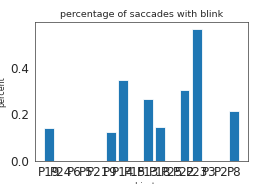

<function matplotlib.pyplot.show(block=None)>

In [64]:
plt.figure()
plt.bar(blink_to_sac.keys(),blink_to_sac.values())
plt.xlabel('subject')
plt.ylabel('percent')
plt.title('percentage of saccades with blink')
plt.show

<IPython.core.display.Javascript object>


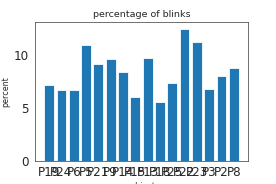

<function matplotlib.pyplot.show(block=None)>

In [65]:
plt.figure()
plt.bar(blink_to_events.keys(),blink_to_events.values())
plt.xlabel('subject')
plt.ylabel('percent')
plt.title('percentage of blinks')
plt.show

<IPython.core.display.Javascript object>


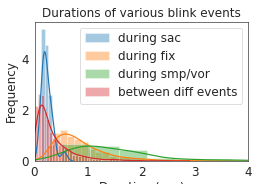

In [66]:
plt.figure()
a = seq.loc[(seq.event=='sac') & (seq.has_blink==1),'duration']
b = seq.loc[(seq.event=='fix') & (seq.has_blink==1),'duration']
c = seq.loc[(seq.event=='smp') & (seq.has_blink==1),'duration']
d = seq.loc[(seq.event=='blink'),'duration']
for key, value in {'during sac':a,'during fix':b,'during smp/vor':c,'between diff events':d}.items():
    sns.distplot(value,label=key)
plt.title('Durations of various blink events',fontsize=15)
plt.xlabel('Duration (sec)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend()
plt.xlim([0,4])
plt.show()

In [67]:
seq.groupby(['subID','task']).size()

subID  task    
P13    cereal       445
       sandwich    2683
P14    cereal       832
       sandwich    2494
P15    cereal       628
P18    cereal       483
       sandwich    1886
P19    cereal       866
       sandwich    2299
P2     cereal       624
P21    cereal       753
P22    cereal       961
       sandwich    3819
P23    cereal      1144
       sandwich    5091
P24    cereal       905
       sandwich    3061
P25    cereal      1608
       sandwich    3812
P3     cereal       967
       sandwich    2355
P5     cereal       436
       sandwich    1464
P6     cereal       659
       sandwich    2240
P8     sandwich    4504
P9     cereal       799
       sandwich    1652
dtype: int64

<IPython.core.display.Javascript object>


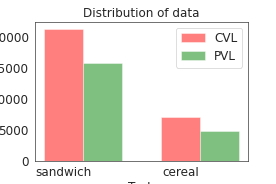

{'CVL': [21431, 7204], 'PVL': [15929, 4906]}


In [68]:
# visualize the spread of data in vision loss and task

colors = ['red','green','blue','gold','purple','orange','pink','grey','brown']

fig, ax = plt.subplots() # Set the plot size

objects = seq.task.value_counts()
targets = list(objects.index)
counts = objects.values
y_pos = np.arange(len(targets))

vls = seq.VL.unique().tolist()
d = {vl:[] for vl in vls}

for i in y_pos:
    objects_vl = dict(seq[seq.task==targets[i]].VL.value_counts())
    for k,v in objects_vl.items():
        d[k].append(v)
print(d)
w = 1/(len(d.items())+1)
for k,v in d.items():        
    i = list(d.keys()).index(k)
    ax.bar(y_pos+i*w, v, color = colors[i], align='center', alpha=0.5, width=w)
    

ax.set_ylabel('Number of Events', fontsize=15)
ax.set_title('Distribution of data', fontsize=15)
plt.xticks(y_pos, targets, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Length of data')
plt.xlabel('Task', fontsize=15)
ax.legend(vls,fontsize=15)

plt.show()

<IPython.core.display.Javascript object>


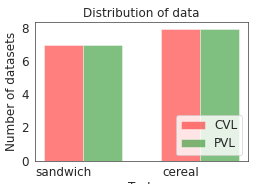

{'CVL': [21431, 7204], 'PVL': [15929, 4906]}


In [69]:
# visualize the spread of data in vision loss and task

colors = ['red','green','blue','gold','purple','orange','pink','grey','brown']

fig, ax = plt.subplots() # Set the plot size

objects = seq.task.value_counts()
targets = list(objects.index)
counts = objects.values
y_pos = np.arange(len(targets))

vls = seq.VL.unique().tolist()
d = {vl:[] for vl in vls}

for i in y_pos:
    objects_vl = dict(seq[seq.task==targets[i]].VL.value_counts())
    for k,v in objects_vl.items():
        d[k].append(v)
print(d)
d = {'PVL':[7,8], 'CVL':[7,8]}
w = 1/(len(d.items())+1)
for k,v in d.items():        
    i = list(d.keys()).index(k)
    ax.bar(y_pos+i*w, v, color = colors[i], align='center', alpha=0.5, width=w)
    

#ax.set_ylabel('Number of Events', fontsize=15)
ax.set_title('Distribution of data', fontsize=15)
plt.xticks(y_pos, targets, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Number of datasets', fontsize=15)
plt.xlabel('Task', fontsize=15)
ax.legend(vls,loc='lower right', fontsize=15)

plt.show()

In [70]:
# # Remove blinks and loss from analysis
# seq = seq[seq.event!='loss'][seq.event!='blink'][seq.event!='noise']
states = ['fix','smp','sac','blink']

In [71]:
seq[seq.event=='smp'].loc[:,['cov_x', 'cov_y', 'cov_xy', 'avg_vel', 'amplitude', 'duration', 'avg_vel', 'max_vel', 'carpenter_error']].describe()

,cov_x,cov_y,cov_xy,avg_vel,amplitude,duration,avg_vel,max_vel,carpenter_error
count,9590.000000,9590.000000,9590.000000,9590.000000,9590.000000,9590.000000,9590.000000,9590.000000,9590.000000
mean,22.847752,11.180732,0.985753,90.234893,10.424867,0.508641,90.234893,663.852167,11.425560
std,42.935057,29.689190,20.478080,333.397833,7.637437,0.453858,333.397833,608.378022,11.812378
min,0.010351,0.006878,-446.511483,-9133.919976,1.500833,0.060013,-9133.919976,-266.475106,0.063289
25%,3.521823,1.338760,-2.433868,60.069583,5.397409,0.215087,60.069583,397.986235,4.290842
50%,8.722442,3.770122,0.295761,105.819964,8.325996,0.375121,105.819964,635.575605,7.770547
75%,24.045184,10.295405,3.329248,148.961387,13.108573,0.640222,148.961387,765.061207,14.037615
max,868.077649,940.080345,686.571914,4633.874089,78.486784,6.897418,4633.874089,14051.808991,160.226766


In [72]:
seq[seq.event=='sac'].loc[:,['has_blink', 'P_fix', 'P_smp', 'P_sac', 'P_blink']].describe()

,has_blink,P_fix,P_smp,P_sac,P_blink
count,12137.000000,11862.000000,1.186200e+04,1.186200e+04,1.186200e+04
mean,0.001730,0.196210,1.351967e-01,7.053181e-01,9.847192e-02
std,0.041562,0.214715,2.018287e-01,3.044882e-01,1.916697e-01
min,0.000000,0.000000,0.000000e+00,9.631466e-31,5.839142e-10
25%,0.000000,0.000001,3.263378e-11,5.182356e-01,1.364651e-03
50%,0.000000,0.129966,8.651903e-03,7.954936e-01,1.310320e-02
75%,0.000000,0.349238,2.309454e-01,9.795721e-01,7.780995e-02
max,1.000000,0.997740,9.977399e-01,1.000000e+00,1.000000e+00


<IPython.core.display.Javascript object>


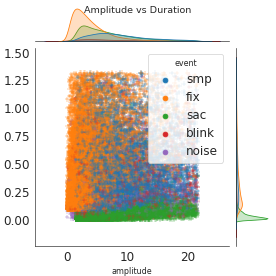

Text(0.5, 0.98, 'Amplitude vs Duration')

In [73]:
# Plot amp vs duration scatter

p = sns.jointplot(data=seq[seq.event!='loss'][seq.amplitude < seq.amplitude.quantile(.95)][seq.duration < seq.duration.quantile(.95)],
              x='amplitude',
              y='duration',
              hue='event',
              marker='+'
             )
p.fig.suptitle('Amplitude vs Duration')

<IPython.core.display.Javascript object>


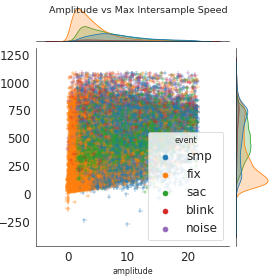

Text(0.5, 0.98, 'Amplitude vs Max Intersample Speed')

In [74]:
# Plot amp vs duration scatter

p = sns.jointplot(data=seq[seq.event!='loss'][seq.amplitude < seq.amplitude.quantile(.95)][seq.max_vel < seq.max_vel.quantile(.95)],
              x='amplitude',
              y='max_vel',
              hue='event',
              marker='+'
             )
p.fig.suptitle('Amplitude vs Max Intersample Speed')

<IPython.core.display.Javascript object>


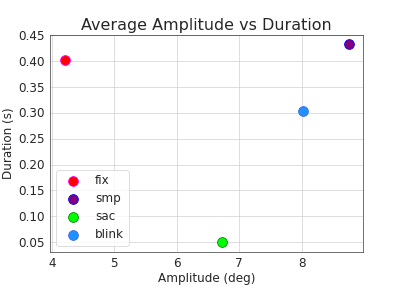

In [75]:
plt.figure(figsize=(7,5))

for state in states:
    a = seq[seq.event == state][seq.amplitude < seq.amplitude.quantile(.95)].amplitude
    b = seq[seq.event == state][seq.duration < seq.duration.quantile(.95)].duration
    
    plt.scatter(np.average(a),np.average(b),s=150,color=COLORS[state],edgecolors=BORDERS[state],label=state)
    
    #if len(a) > len(b): a = a[:len(b)]
    #else: b = b[:len(a)]
    
    #plt.scatter(a,b,s=0.5,alpha=0.2,color=COLORS[state])
        
plt.title('Average Amplitude vs Duration', fontsize=20)
plt.xlabel('Amplitude (deg)',fontsize=15)
plt.ylabel('Duration (s)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


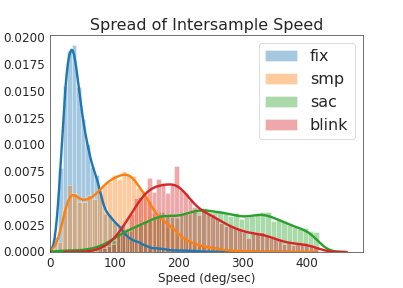

In [76]:
# Plot histograms of features
# Only keep data falling within the 95% quantiles (right-tail truncated)

# Speed
plt.figure(figsize=(7,5))
for state in states:
    try:
        sns.distplot(seq[seq.event == state][seq.avg_iss < seq.avg_iss.quantile(.95)].avg_iss, kde_kws=dict(linewidth=3), bins = 50, label = state)
    except: pass
plt.title('Spread of Intersample Speed', fontsize=20)
plt.xlabel('Speed (deg/sec)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.legend(fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


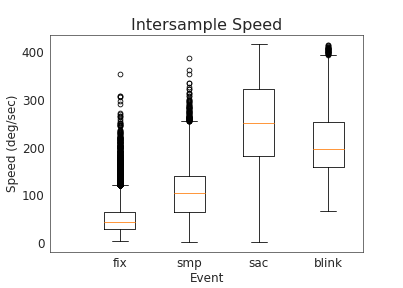

In [77]:
plt.figure(figsize=(7,5))
data = []
for state in states:
    data.append((seq[seq.event == state][seq.avg_iss < seq.avg_iss.quantile(.95)].avg_iss))
plt.boxplot(data, labels = states)
plt.title('Intersample Speed', fontsize=20)
plt.xlabel('Event', fontsize=15)
plt.ylabel('Speed (deg/sec)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()



<IPython.core.display.Javascript object>


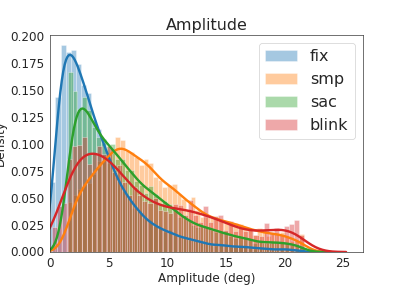

In [78]:
# Amplitude
plt.figure(figsize=(7,5))
for state in states:
    sns.distplot(seq[seq.event == state][seq.amplitude < seq.amplitude.quantile(.95)].amplitude, bins = 50, kde_kws=dict(linewidth=3), label = state)
plt.title('Amplitude',fontsize=20)
plt.xlabel('Amplitude (deg)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


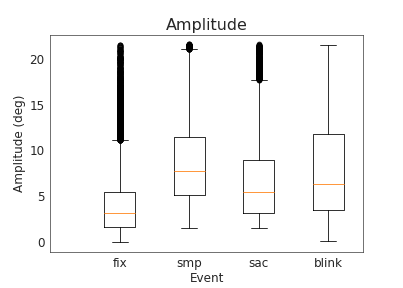

In [79]:

plt.figure(figsize=(7,5))
data = []
for state in states:
    data.append((seq[seq.event == state][seq.amplitude < seq.amplitude.quantile(.95)].amplitude))
plt.boxplot(data, labels = states)
plt.title('Amplitude', fontsize=20)
plt.xlabel('Event', fontsize=15)
plt.ylabel('Amplitude (deg)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


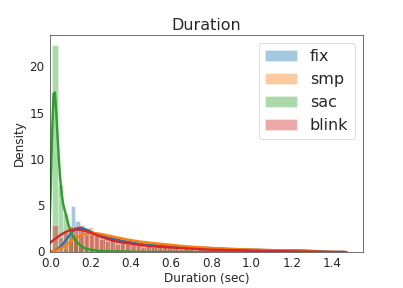

In [80]:
# Duration
#states = seq.event.unique()

plt.figure(figsize=(7,5))
for state in states:
    sns.distplot(seq[seq.event == state][seq.duration < seq.duration.quantile(.95)].duration, bins = 50, kde_kws=dict(linewidth=3), label = state)
plt.title('Duration',fontsize=20)
plt.xlabel('Duration (sec)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


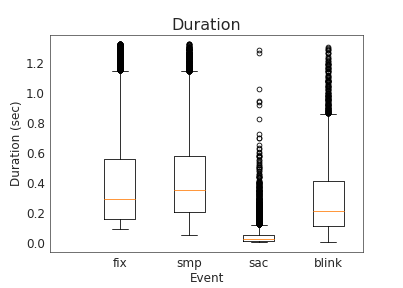

In [81]:
plt.figure(figsize=(7,5))
data = []
for state in states:
    data.append((seq[seq.event == state][seq.duration < seq.duration.quantile(.95)].duration))
plt.boxplot(data, labels = states)
plt.title('Duration', fontsize=20)
plt.xlabel('Event', fontsize=15)
plt.ylabel('Duration (sec)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()


<IPython.core.display.Javascript object>


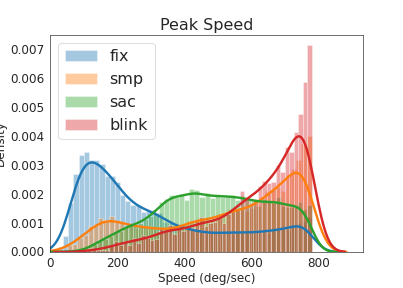

In [82]:
# Max Speed
plt.figure(figsize=(7,5))
for state in states:
    sns.distplot(seq[seq.event == state][seq.max_iss < seq.max_iss.quantile(.95)].max_iss, bins = 50, kde_kws=dict(linewidth=3), label = state)
plt.title('Peak Speed',fontsize=20)
plt.xlabel('Speed (deg/sec)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


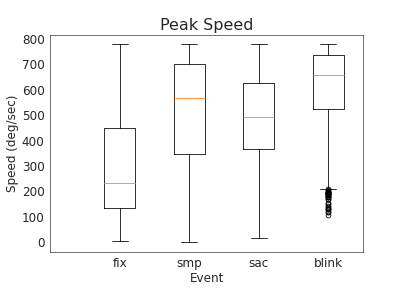

In [83]:
plt.figure(figsize=(7,5))
data = []
for state in states:
    data.append((seq[seq.event == state][seq.max_iss < seq.max_iss.quantile(.95)].max_iss))
plt.boxplot(data, labels = states)
plt.title('Peak Speed', fontsize=20)
plt.xlabel('Event', fontsize=15)
plt.ylabel('Speed (deg/sec)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

In [84]:
# percentage of saccades with duration > 200ms (carpenter p.67)
len(seq.loc[(seq.event=='sac')&(seq.duration>0.2)])/len(seq[seq.event=='sac'])*100

2.4388234324791958

In [85]:
print("median  ", seq.loc[(seq.event=='sac')&(seq.duration>0.2)].carpenter_error.median())
print(seq.loc[(seq.event=='sac')&(seq.duration>0.2)].carpenter_error.describe())

median   2.744270722230254
count    296.000000
mean       5.100982
std        7.481376
min        0.196023
25%        1.757247
50%        2.744271
75%        5.759903
max       88.856078
Name: carpenter_error, dtype: float64


In [86]:
# percentage of saccades with duration > 200ms (carpenter p.67)
len(seq.loc[(seq.event=='sac')&(seq.duration>0.2)])/len(seq[seq.event=='sac'])*100

2.4388234324791958

In [87]:
print(seq.loc[(seq.event=='sac')&(seq.duration>0.2)].carpenter_error.describe())

count    296.000000
mean       5.100982
std        7.481376
min        0.196023
25%        1.757247
50%        2.744271
75%        5.759903
max       88.856078
Name: carpenter_error, dtype: float64


<IPython.core.display.Javascript object>


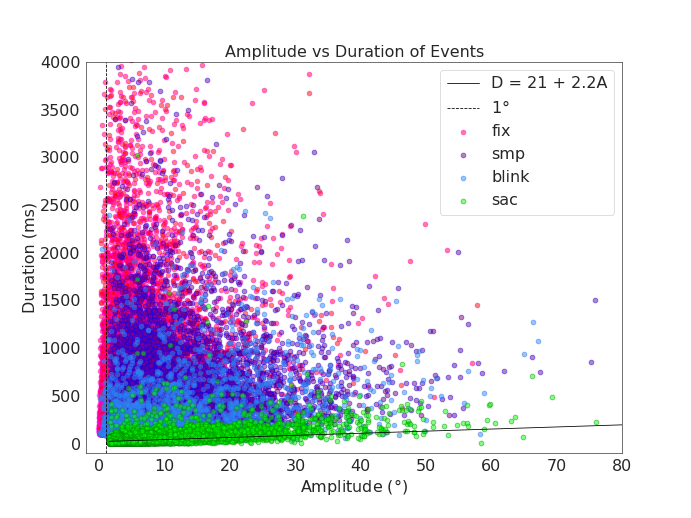

In [88]:
# Plot Carpenter relation
plot_carpenter(seq, show_events=['fix','smp','blink','sac'])

<IPython.core.display.Javascript object>


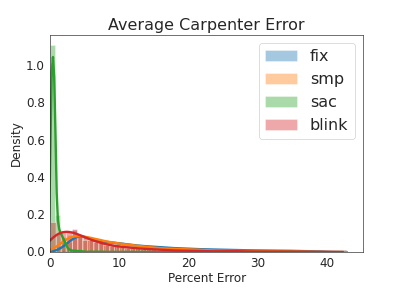

In [89]:
# Print Carpenter spread
# Amplitude
plt.figure(figsize=(7,5))
for state in states:
    sns.distplot(seq[seq.event == state][seq.carpenter_error < seq.carpenter_error.quantile(.95)].carpenter_error, bins = 50, kde_kws=dict(linewidth=3), label = state)
plt.title('Average Carpenter Error',fontsize=20)
plt.xlabel('Percent Error', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


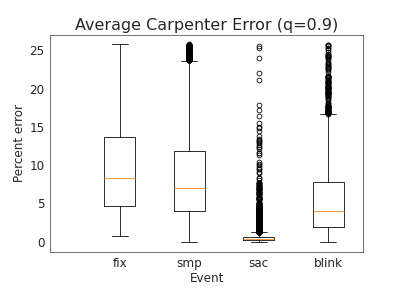

In [90]:
plt.figure(figsize=(7,5))
data = []
q = .9
for state in states:
    data.append((seq[seq.event == state][seq.carpenter_error < seq.carpenter_error.quantile(q)].carpenter_error))
plt.boxplot(data, labels = states)
plt.title(f'Average Carpenter Error (q={q})', fontsize=20)
plt.xlabel('Event', fontsize=15)
plt.ylabel('Percent error', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0)
plt.show()

<IPython.core.display.Javascript object>


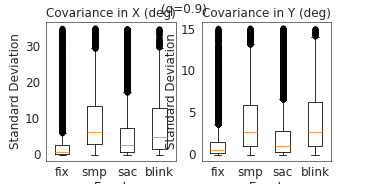

In [91]:
#%matplotlib inline

states = ['fix','smp','sac','blink']

q =.9

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#plt.figure(figsize=(7,5))
data = []
for state in states:
    data.append((seq[seq.event == state][seq.cov_x < seq.cov_x.quantile(q)].cov_x))
axes[0].boxplot(data, labels = states)
axes[0].set_title('Covariance in X (deg)', fontsize=15)
axes[0].set_xlabel('Event', fontsize=15)
axes[0].set_ylabel('Standard Deviation', fontsize=15)


data = []
for state in states:
    data.append((seq[seq.event == state][seq.cov_y < seq.cov_y.quantile(q)].cov_y))
axes[1].boxplot(data, labels = states)
axes[1].set_title('Covariance in Y (deg)', fontsize=15)
axes[1].set_xlabel('Event', fontsize=15)
axes[1].set_ylabel('Standard Deviation', fontsize=15)

plt.suptitle(f'(q={q})',fontsize=15)

#data = []
#for state in states:
#    data.append((seq[seq.event == state][seq.cov_xy < seq.cov_xy.quantile(.95)].cov_xy))
#axes[2].boxplot(data, labels = states)
#axes[2].set_title('Covariance in XY (deg)', fontsize=15)
#axes[2].set_xlabel('Event', fontsize=10)
#axes[2].set_ylabel('Covariance', fontsize=10)



plt.show()